# SFDC Profile: Disney Integration
## Goals: Gather Information Based Off Disney Conversion Process


In [25]:
 # Need to import unittestmock for dummy data on the json, salesforce connector, and json
from unittest.mock import MagicMock
from faker import Faker
import json
import os
import subprocess
import time
import datetime
import dateutil.parser
from simple_salesforce import Salesforce
faker = Faker()

In [47]:
##############################
# Org specific Information - #       
#   Fill Out the Following:  #
#      * Username            #
#      * Password            #
#      * Security Token      #
#      * Property Code       #
#      * Name of Floor Plan  #
#      * Name of Parking     #
##############################
username ='notify+devorg_project_disney_r3_13217@fortimize.com'
pw = '_1V9|1h7-P'
token = 'EE6GyOKBcOzvKRbKLc9g4eAjJ'
property_code = "1310"
floor_plan_name = 'Floor Plan 2FT 2BERM'
parking_name = 'Test Covered Parking'

In [38]:
# Build out simple connector class that establishes a REST connection to SFDC
# DO NOT EDIT
class Connector(object):
    def __init__(self,username,pw,token,isSandbox):
        self.username = username
        self.pw=pw
        self.token=token
        self.isSandbox = isSandbox
        self.make_connection()
    def make_connection(self):
        if self.isSandbox:
            self.sf = Salesforce(username=self.username, password=self.pw, security_token=self.token, domain='test')
        else:
            self.sf= Salesforce(username=self.username, password=self.pw, security_token=self.token)
    def get_sf(self):
        return self.sf

connection = Connector(username,pw,token,True)


In [39]:
def delete_templates():       
    templates = connection.sf.query('Select Id FROM Integration_Template__c')['records']
    connection.sf.bulk.Integration_Template__c.delete([{'Id':record['Id']} for record in templates])
def delete_cases():
    cases = connection.sf.query('Select ID From Case')['records']
    connection.sf.bulk.Case.delete([{'Id':record['Id']} for record in cases])
def delete_accounts():
    accounts = connection.sf.query('Select Id FROM Account')['records']
    connection.sf.bulk.Account.delete([{'Id':record['Id']} for record in accounts])
def delete_apps():
    applications = connection.sf.query('Select Id FROM Application__c')['records']
    connection.sf.bulk.Application__c.delete([{'Id':record['Id']} for record in applications])
def delete_leases():    
    leases = connection.sf.query('Select Id FROM Contract')['records']
    connection.sf.bulk.Contract.delete([{'Id':record['Id']} for record in leases])
def purge_data():
    delete_templates()
    delete_cases()
    delete_accounts()
    delete_apps()
    #delete_leases()
    



In [40]:
# DO NOT EDIT
class LeasableItems():
    def __init__(self,sf):
        self.sf=sf.sf
    def get_id(self,name):
        self.records = self.sf.query("SELECT ID FROM Product2 WHERE Name ='{}'".format(name))
        return self.records['records'][0]['Id']
        
parkingItem = LeasableItems(connection)

floor_plan=LeasableItems(connection)
        

In [41]:
# DO NOT EDIT
class ApexAsyncJob():
    def __init__(self,sf):
        self.sf=sf.sf
    def get_record(self):
        self.record = self.sf.query("Select Id,CompletedDate,ExtendedStatus,JobItemsProcessed,JobType,MethodName,NumberOfErrors,Status,TotalJobItems,CreatedDate FROM AsyncApexJob WHERE ApexClass.Name='FMZ_BatchIntegrationConversion' ORDER BY CreatedDate DESC")
        return self.record['records'][0]
    def set_id_list(self,record_list):
        self.id_list = [i['Id'] for i in record_list]        
    def create_set_string(self):
        set_string = "("
        for i,id_ in enumerate(self.id_list):
            if i != len(self.id_list)-1:
                set_string+="'"+id_+"'"+","
            else:
                set_string+="'"+id_+"'"
        set_string+=")"
        return set_string
    def query_on_ids(self,set_string):
        self.records = self.sf.query("Select Id,CompletedDate,ExtendedStatus,JobItemsProcessed,JobType,MethodName,NumberOfErrors,Status,TotalJobItems,CreatedDate FROM AsyncApexJob WHERE ApexClass.Name='FMZ_BatchIntegrationConversion' AND ID IN {} ORDER BY CreatedDate DESC".format(set_string))['records']
        return self.records
        
        
    
        


### Create JSON that mimics the following format

<code>
 {
  "participantList":[
       {
         "Street":"34 Montclair Ave",
         "State":"New York",
         "Region":"United States",
         "PropertyCode":"1310",
         "PreferredName":"Davarious Leeroy",
         "PostalCode":"11752",
         "Mobile":"347-879-1231",
         "MobileCountryCode":"US",
         "MiddleName":"Thomas",
         "LastName":"Leeroy",
         "HousingGender":"Male",
         "FirstName":"Davarious",
         "EmergencyContactRelationship"  : "Mother",
         "EmergencyContactPhone":"203-123-1231",
         "EmergencyContactName":"Tessa Kline",
         "EmergencyContactCountryCode":"US",
         "Email":"mchen@hotmail.com",
         "DOB":"1994-04-04",
         "City":"Selden",
         "CandidateRefNum":"bee8cde6-8965-4aea-8fa9-7c5fafcdc27e-23423-sfvval",
         "floorPlan":
            {
               "LeasableItemId":"01t54000006lcZiAAI",
                "UnitAssignInDate":"2020-01-01",
                 "UnitAssignOutDate": "2020-06-06",
                 "Building": "B1000",
                 "Floor": "T1",
                 "Unit": "01"
            },
          "parkingList":[
            {
                "VehicleState":"New York",
                "VehicleModel":"Cruze",
                "VehicleMake":"Chevy",
                "VehicleColor":"Red",
                 "VehicleYear":"2014",
                "LicensePlate":"HWM-2821",
                "LeasableItemId":"01t54000006m6fFAAQ"
            }
          ]
      }
   ]
}
</code>

In [42]:

class FakeData():
    def __init__(self,num,floor_name,parking_name):
        self.floor_name = floor_name
        self.parking_name=parking_name
        self.dataDict = {
            "participantList":[]
        }
        self.gen_data(num)
    def gen_data(self,num):
        for i in range(0,num):
            self.dataDict['participantList'].append(self.create_dict())
        
    def create_dict(self):
        return {
         "Street":faker.street_address(),
         "State":faker.state(),
         "Region":"United States",
         "PropertyCode":property_code,
         "PreferredName":faker.name(),
         "PostalCode":faker.zipcode(),
         "Mobile":faker.phone_number(),
         "MobileCountryCode":"US",
         "MiddleName":faker.last_name(),
         "LastName":faker.last_name(),
         "HousingGender":"Male",
         "FirstName":faker.first_name_male(),
         "EmergencyContactRelationship": "Mother",
         "EmergencyContactPhone":faker.phone_number(),
         "EmergencyContactName":faker.name_female(),
         "EmergencyContactCountryCode":"US",
         "Email":faker.ascii_email(),
         "DOB":faker.date(pattern='%Y-%m-%d',end_datetime=None),
         "City":faker.city(),
         "CandidateRefNum":faker.sha1(),
         "floorPlan":
            {
                "LeasableItemId":floor_plan.get_id(self.floor_name),
                "UnitAssignInDate":faker.date_between(start_date='-30d', end_date='today').isoformat(),
                 "UnitAssignOutDate": faker.date_between(start_date='+30d', end_date='+60d').isoformat(),
                 "Building": "B1000",
                 "Floor": "T1",
                 "Unit": "01"
            },
          "parkingList":[
            {
                "VehicleState": faker.state(),
                "VehicleModel":"Cruze",
                "VehicleMake":"Chevy",
                "VehicleColor":"Red",
                 "VehicleYear":faker.year(),
                "LicensePlate":faker.license_plate(),
                "LeasableItemId":floor_plan.get_id(self.parking_name)
            }
          ]            
        }
        


In [45]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
from streamz.dataframe import DataFrame
from streamz import Stream
from IPython.display import display, HTML, clear_output

style.use('fivethirtyeight')

stream = Stream()
example = pd.DataFrame({
    'Id':[],
    'CompletedDate':[],
    'ExtendedStatus':[],
    'JobItemsProcessed':[],
    'JobType':[],
    'MethodName':[],
    'NumberOfErrors':[],
    'Status':[],
    'TotalJobItems':[],
    'CreatedDate':[]                        
    })
example.set_index('Id')

class Simulator():
    
    def __init__(self,num_templates,num_trials,async_apex):
        
        self.num_templates = num_templates
        self.num_trials = num_trials
        self.async_apex =async_apex
        self.timeout = 15 if self.num_templates < 10 else self.num_templates* 2.5
        self.record_list = []; # hold the id of the async apex job
        self.graph_data = []
        # Initiate plot
        self.init_plot()
    def init_plot(self):
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency')
        plt.title('{} Template(s) for {} trial(s)'.format(self.num_templates,self.num_trials))
    
    def post_templates(self):
        payload = FakeData(self.num_templates,floor_plan_name,parking_name).dataDict
        connection.sf.apexecute('integration/disney', method='POST', data=payload) # post templates
        # Start the batch
        os.system('sfdx force:apex:execute -f ./anon.apex -u '+connection.username)
    def calculate_time_diff(self,record):
        start_datetime = dateutil.parser.parse(record['CreatedDate'])
        end_datetime= dateutil.parser.parse(record['CompletedDate'])
        return end_datetime- start_datetime
    def validate_records(self):
        
        while len(self.async_apex.records)!=0:
            time.sleep(3)
            for i,record in enumerate(self.async_apex.records):
                if record['CompletedDate'] is not None:
                    self.graph_data.append(
                        self.calculate_time_diff(self.async_apex.records.pop(i)).total_seconds()
                    )
                    clear_output(wait=True)
                    print(pd.Series(self.graph_data).describe())
                    
                    
                    
            self.async_apex.set_id_list(self.async_apex.records)
            if(len(self.async_apex.id_list)!=0):
                set_string = self.async_apex.create_set_string()
                self.async_apex.query_on_ids(set_string)
        plt.hist(self.graph_data) 
        plt.show()      
                                                     
    def simulate(self): 
    
        for i in range(0,self.num_trials):
            self.post_templates()
            time.sleep(3)
            record = self.async_apex.get_record()
            self.record_list.append(record)
            
        self.async_apex.set_id_list(self.record_list)
        set_string = self.async_apex.create_set_string()
        self.async_apex.query_on_ids(set_string)
        self.validate_records()        
        #self.calculate_time_diff(record)
                  
async_apex = ApexAsyncJob(connection)




In [ ]:
simulator_1_for_1 = Simulator(num_templates=1,num_trials=1,async_apex=async_apex)
simulator_1_for_1.simulate()

count    10.000000
mean     18.000000
std      10.832051
min       5.000000
25%       8.000000
50%      18.000000
75%      25.500000
max      34.000000
dtype: float64


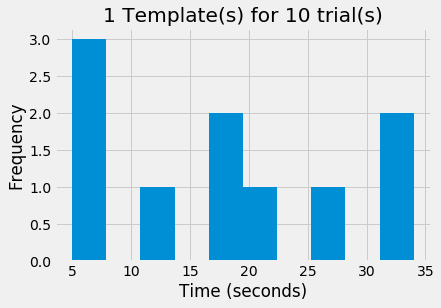

In [23]:
simulator_1_for_10 = Simulator(num_templates=1,num_trials=10,async_apex= async_apex)
simulator_1_for_10.simulate()

count     10.000000
mean     231.900000
std      103.349945
min       58.000000
25%      165.000000
50%      245.500000
75%      312.000000
max      351.000000
dtype: float64


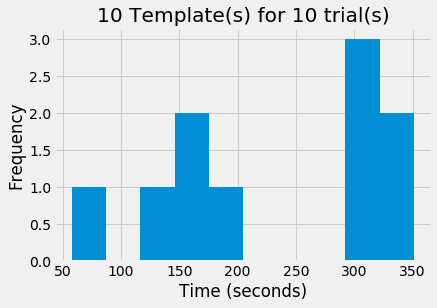

In [24]:
purge_data()
simulator_10_for_10 = Simulator(num_templates=10,num_trials=10,async_apex= async_apex)
simulator_10_for_10.simulate()

SalesforceMalformedRequest: Malformed request https://java-connect-4170.cs94.my.salesforce.com/services/apexrest/integration/disney. Response content: {'Status': 'Unsuccessful', 'Message': 'Insert failed. First exception on row 0; first error: STORAGE_LIMIT_EXCEEDED, storage limit exceeded: []'}

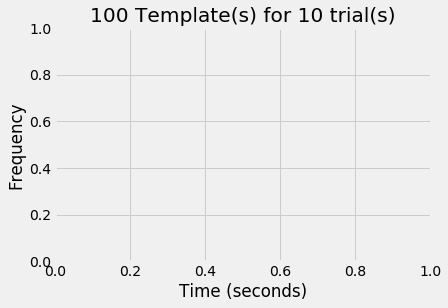

In [36]:
simulator_100_for_10 = Simulator(num_templates=100,num_trials=10,async_apex= async_apex)
simulator_100_for_10.simulate()